# This notebook predicts the number of inmates admitted to the NYC police system each day. It relies on ["Inmate Admissions"](https://data.cityofnewyork.us/Public-Safety/Inmate-Admissions/6teu-xtgp) from NYC Open data. 
## Models: LinearRegression, SARIMA, RELU neural network with Kalman Smoothing

In [1]:
# get the data through the API
import pandas as pd
import requests

# takes url of the dataset, returns a Pandas DataFrame of the dataset
def getNYCdata(url):
    key = "SECRET"
    response = requests.get(url, headers={'X-App-Token': key})
    data = response.text
    df = pd.read_json(data)
    return df

# Daily Admissions
url = "https://data.cityofnewyork.us/resource/6teu-xtgp.json?$limit=500000"
df = getNYCdata(url)

## Clean data 
Tranform data types, replace race and status code values with mappings, create new time features

In [3]:
df['admitted_dt'] = pd.to_datetime(df['admitted_dt'])

In [3]:
race_dict = {"B" : 'Black', "W" : 'White', "A": 'Asian', "I" : 'American-Indian', "O": 'Other', 'U': 'Unknown'}
df=df.replace({"race": race_dict})

In [4]:
set(df['race'].values)
df.race.fillna('Unknown')

0         UNKNOWN
1         UNKNOWN
2           BLACK
3         UNKNOWN
4         UNKNOWN
           ...   
354817    UNKNOWN
354818    UNKNOWN
354819    UNKNOWN
354820      BLACK
354821      BLACK
Name: race, Length: 354822, dtype: object

In [4]:
df.admitted_dt.describe()

<ipython-input-4-e50a955aeb42>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.admitted_dt.describe()


count                  354822
unique                 344153
top       2016-05-22 12:32:00
freq                        7
first     2014-01-01 07:30:00
last      2022-02-28 22:27:44
Name: admitted_dt, dtype: object

In [3]:
gender_dict = {'M': 'Male', 'F': 'Female'}
df=df.replace({"gender": gender_dict})
df['gender']=df.gender.fillna('Unknown')

In [6]:
status_dict = {'CS': 'City Sentenced', 'CSP':'City Sentenced, with VP Warrant',
                'DE': 'Detainee', 'DEP':'Detainee, with Open Case & VP Warrant',
                'DNS': 'Detainee, Newly Sentenced to State Time',
                'DPV': 'Detainee, Technical Parole Violator',
                'SCO': 'State Prisoner, Court Order', 'SSR':'State Ready'}
df=df.replace({"inmate_status_code": status_dict})

In [6]:
# time analysis
df['admitted_wkday'] = df['admitted_dt'].dt.day_of_week
df['admitted_month'] = df['admitted_dt'].dt.month
df['admitted_year'] = df['admitted_dt'].dt.year
df['admitted_date'] = df['admitted_dt'].dt.date
df['admitted_hour'] = df['admitted_dt'].dt.hour
df['admitted_week'] = df['admitted_dt'].dt.weekofyear

<ipython-input-6-ef5b1b941f6f>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['admitted_week'] = df['admitted_dt'].dt.weekofyear


## Transform data for time series prediction - LinearRegressions
lots of help from this Kaggle tutorial: https://www.kaggle.com/ryanholbrook/linear-regression-with-time-series

In [5]:
# make a dataframe with inmates per day
num_inmates = df.groupby("admitted_date").agg({"inmateid": pd.Series.nunique})['inmateid']

KeyError: 'admitted_date'

In [5]:
pred_df = pd.DataFrame(num_inmates)
pred_df = pred_df.reset_index()
pred_df['admitted_date'] = pd.to_datetime(pred_df['admitted_date'])
pred_df['weekly_periods']= pred_df.loc[:, 'admitted_date'].dt.to_period('W')
pred_df=pred_df.rename(columns={'inmateid':'inmateid_count'})
pred_df=pred_df.set_index("weekly_periods")
pred_df

,admitted_date,inmateid_count
weekly_periods,,
2013-12-30/2014-01-05,2014-01-01,84
2013-12-30/2014-01-05,2014-01-02,202
2013-12-30/2014-01-05,2014-01-03,162
2013-12-30/2014-01-05,2014-01-04,107
2013-12-30/2014-01-05,2014-01-05,118
...,...,...
2022-02-21/2022-02-27,2022-02-24,68
2022-02-21/2022-02-27,2022-02-25,58
2022-02-21/2022-02-27,2022-02-26,37


In [11]:
pred_df_week = pred_df.reset_index()
pred_df_week = pred_df_week.drop(columns='admitted_date')

In [12]:
pred_df_week

,weekly_periods,inmateid_count
0,2013-12-30/2014-01-05,84
1,2013-12-30/2014-01-05,202
2,2013-12-30/2014-01-05,162
3,2013-12-30/2014-01-05,107
4,2013-12-30/2014-01-05,118
...,...,...
2976,2022-02-21/2022-02-27,68
2977,2022-02-21/2022-02-27,58
2978,2022-02-21/2022-02-27,37
2979,2022-02-21/2022-02-27,25


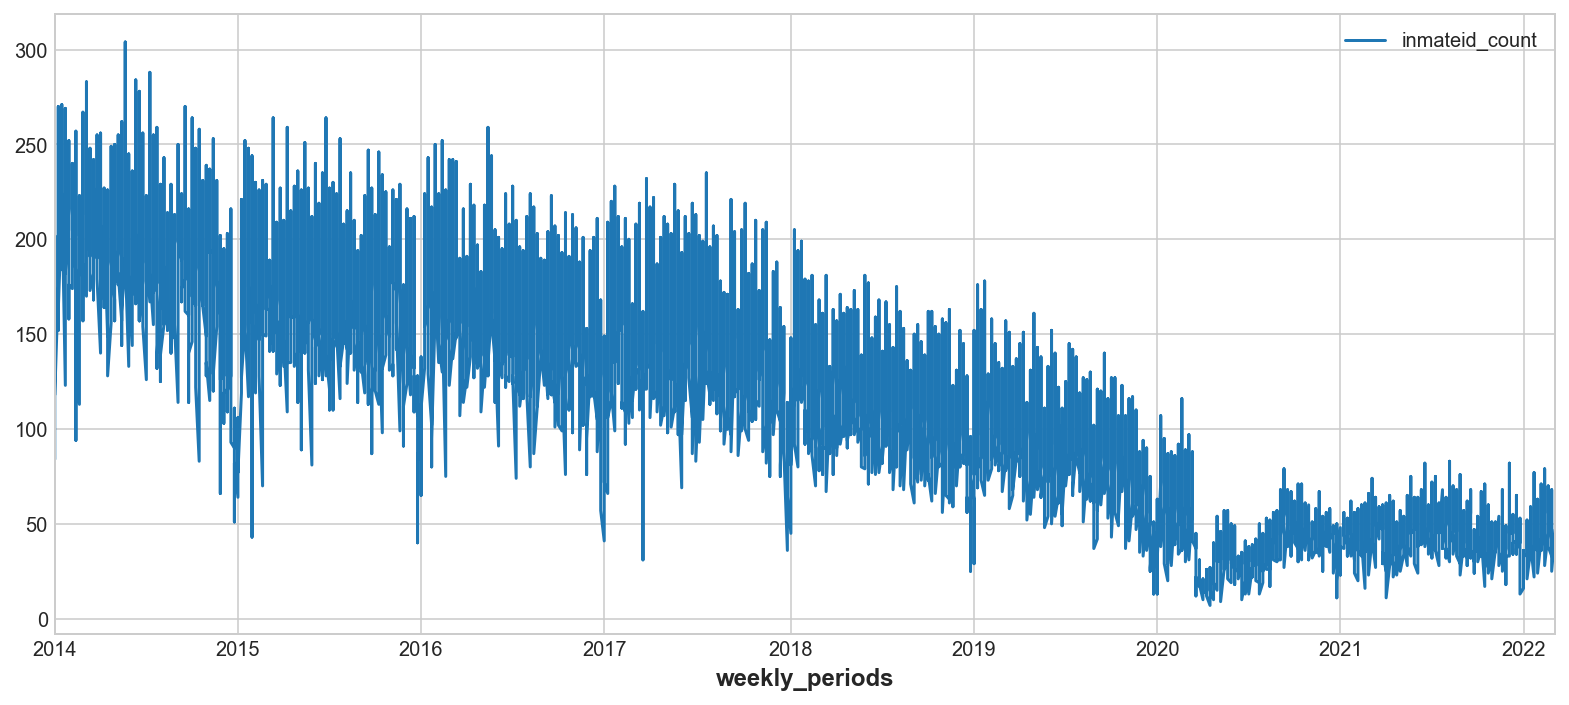

In [15]:
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

pred_df_week.plot.line(x='weekly_periods', y='inmateid_count')

In [10]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=pred_df.weekly_periods,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates

AttributeError: 'DataFrame' object has no attribute 'weekly_periods'

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=pred_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [8]:
y = pred_df.inmateid_count

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Inmate Admissions - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

NameError: name 'X' is not defined

In [ ]:
plot_periodogram(pred_df.inmateid_count)

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #print(date)
        preds.index = pd.period_range(start=date, periods=len(preds)) #periods=len(preds)
        preds.plot(ax=ax)
    return ax


In [9]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = pred_df.inmateid_count.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [10]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

NameError: name 'train_test_split' is not defined

In [11]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print("Test R2", r2) # https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean
# basically, this model fits the data very badly


NameError: name 'mean_squared_error' is not defined

NameError: name 'y_fit' is not defined

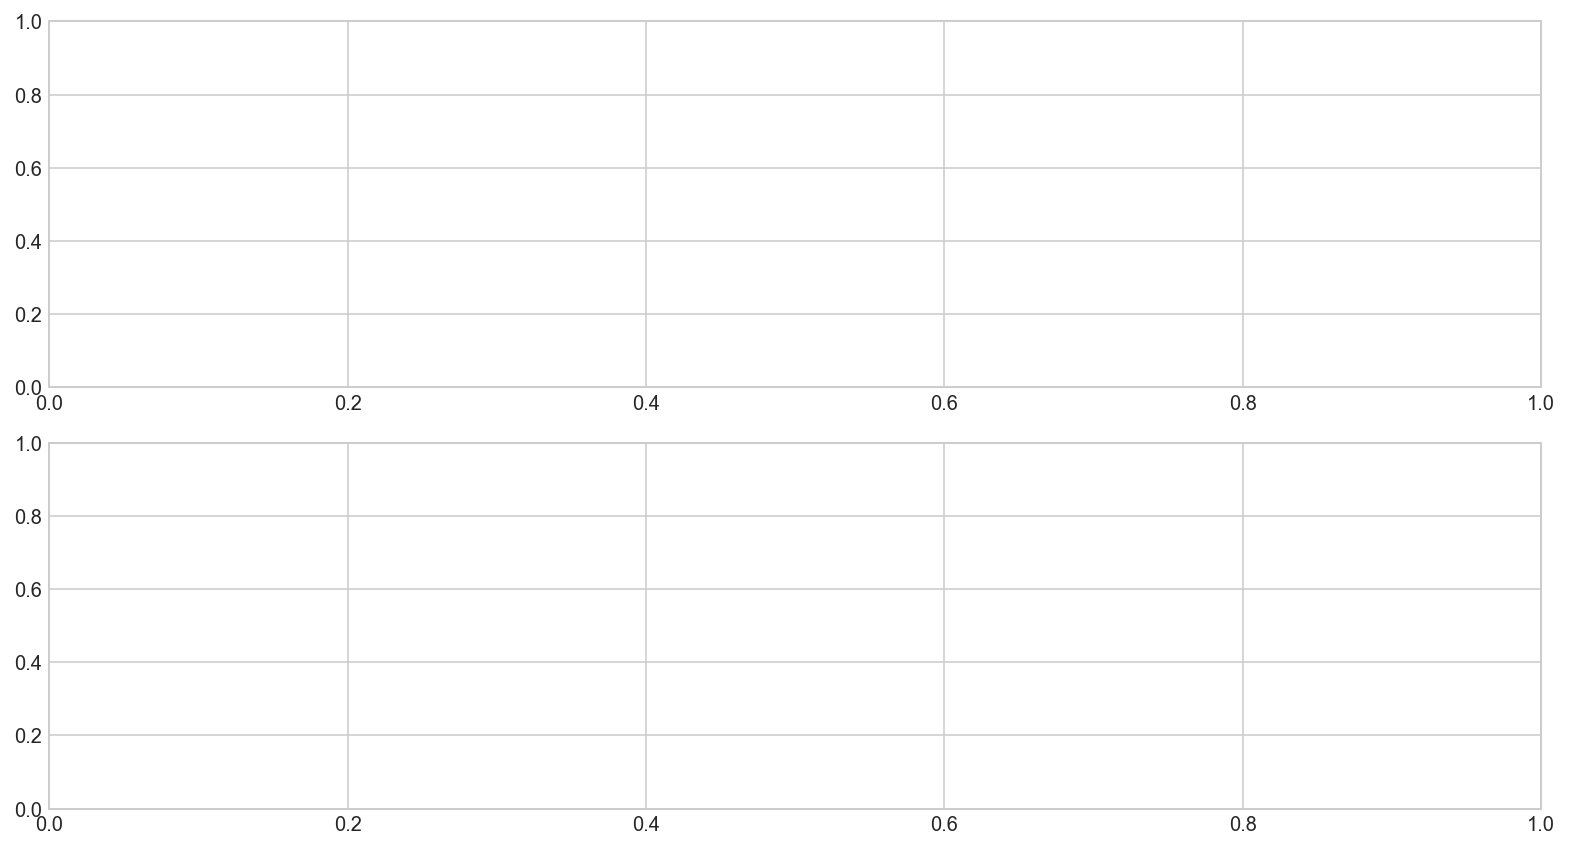

In [12]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = pred_df.inmateid_count[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Inmate Admissions (train)', 'Forecast'])

ax2 = pred_df.inmateid_count[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Inmate Admissions (test)', 'Forecast'])

In [ ]:
print(model.coef_)

In [ ]:
print(model.intercept_)

In [ ]:
X

# SARIMA (Seasonal ARIMA time series forecasting)
## Following Omega Markos' medium article
https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f
and 
https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c

In [13]:
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
#import pmdarima as pm
plt.style.use('ggplot')

In [14]:
pred_df

,admitted_date,inmateid_count
weekly_periods,,
2013-12-30/2014-01-05,2014-01-01,84
2013-12-30/2014-01-05,2014-01-02,202
2013-12-30/2014-01-05,2014-01-03,162
2013-12-30/2014-01-05,2014-01-04,107
2013-12-30/2014-01-05,2014-01-05,118
...,...,...
2022-02-21/2022-02-27,2022-02-24,68
2022-02-21/2022-02-27,2022-02-25,58
2022-02-21/2022-02-27,2022-02-26,37


In [15]:
pred_df_day = pred_df.set_index('admitted_date')
pred_df_day

,inmateid_count
admitted_date,
2014-01-01,84
2014-01-02,202
2014-01-03,162
2014-01-04,107
2014-01-05,118
...,...
2022-02-24,68
2022-02-25,58
2022-02-26,37


In [20]:
pred_df_week = pred_df.drop('admitted_date', axis=1)

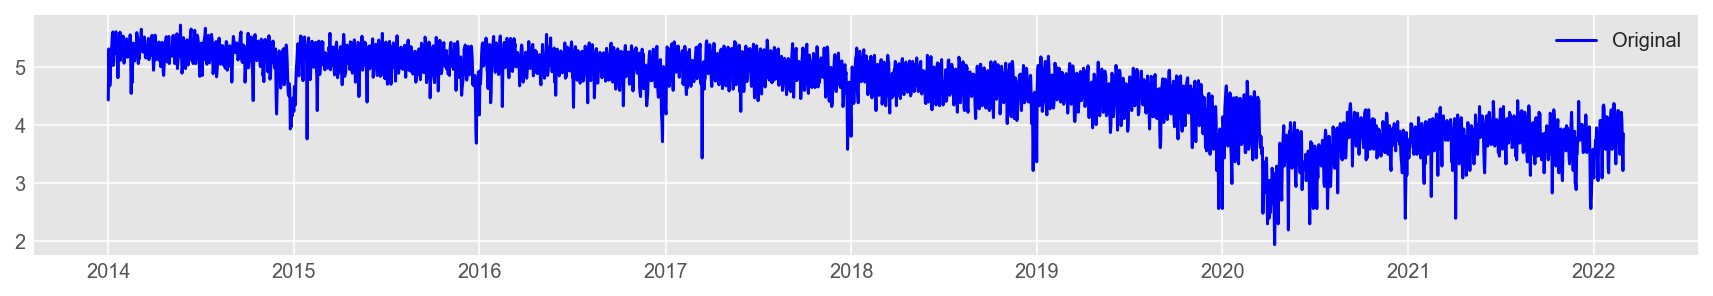

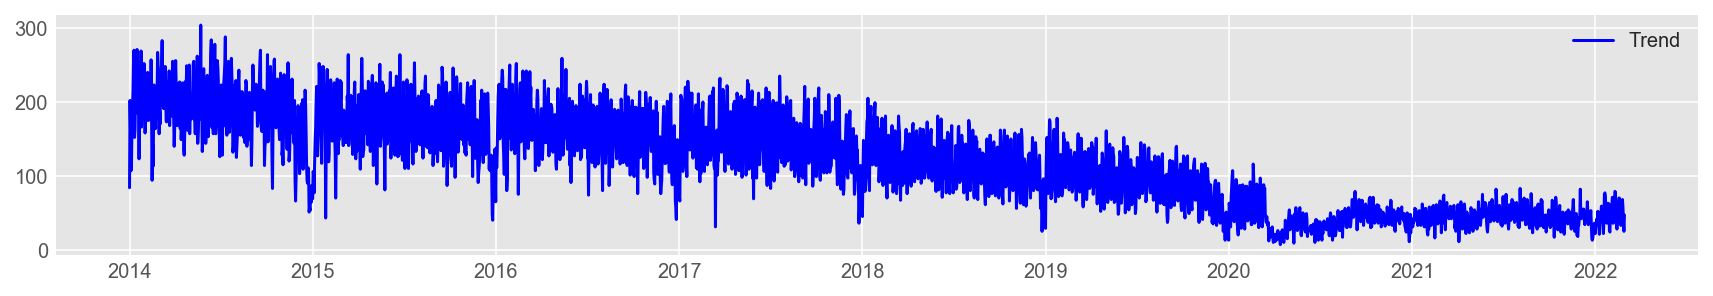

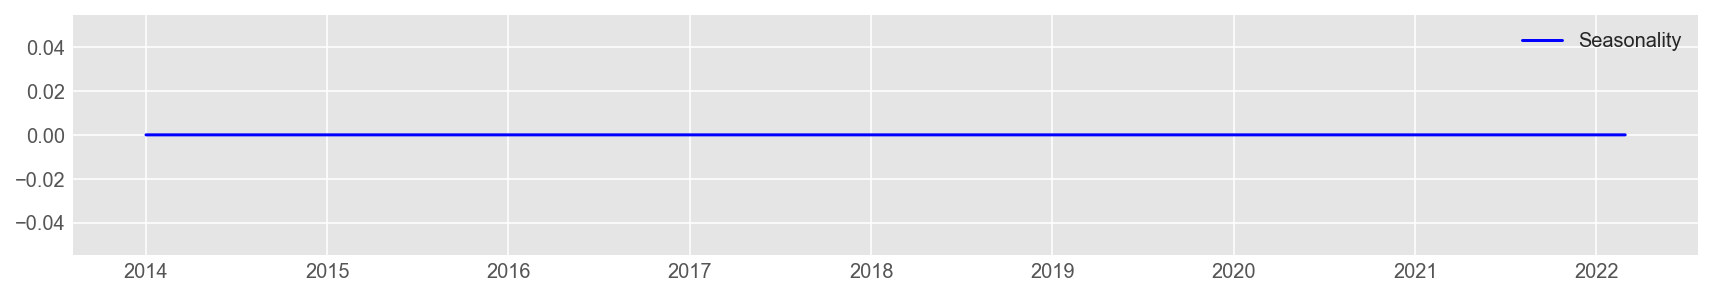

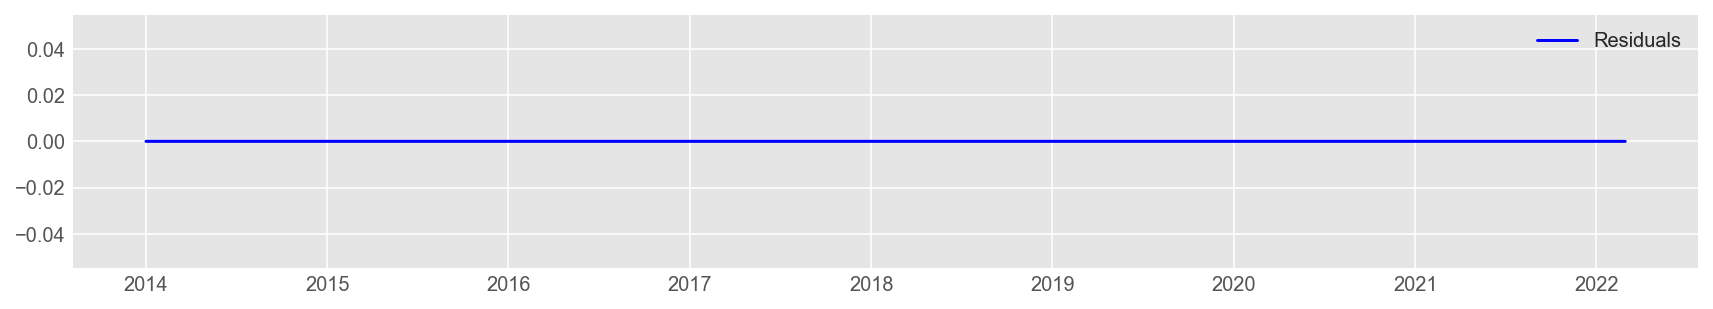

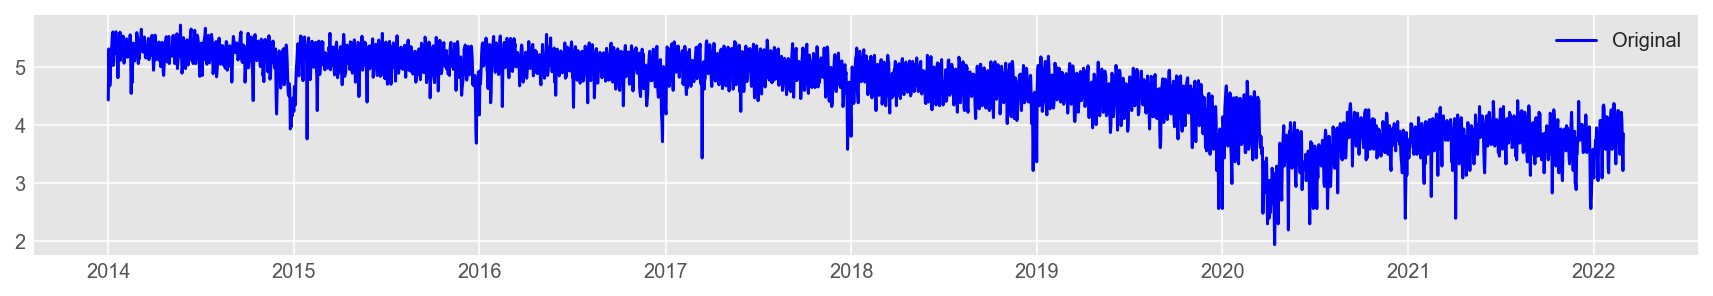

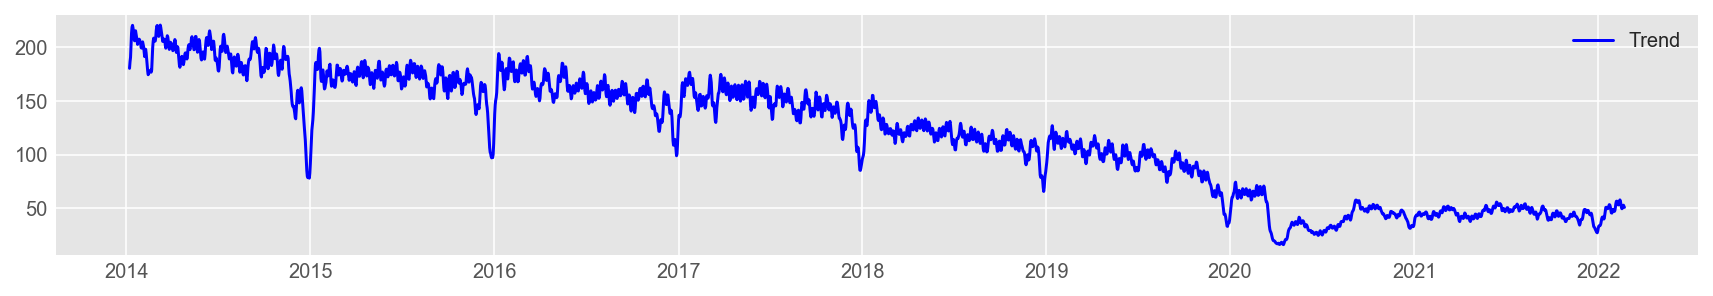

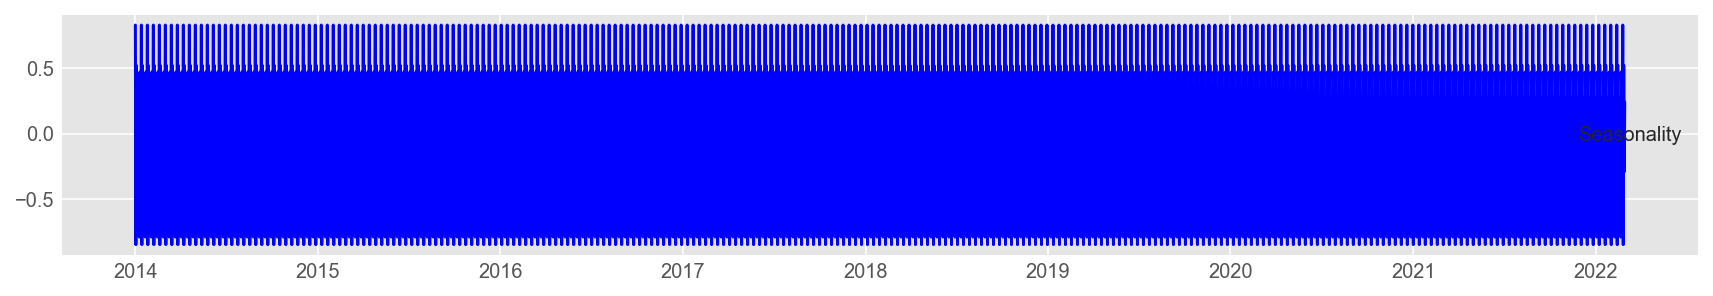

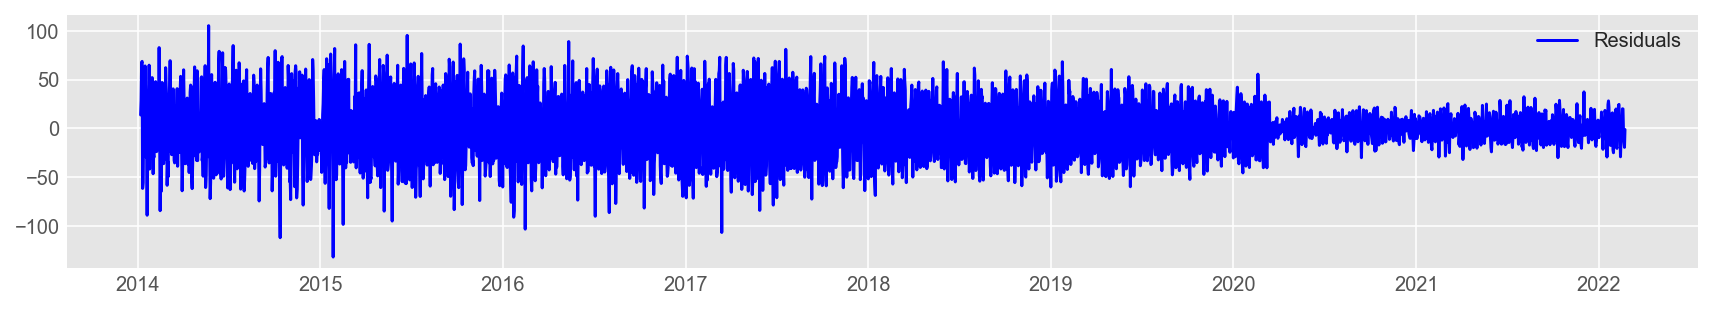

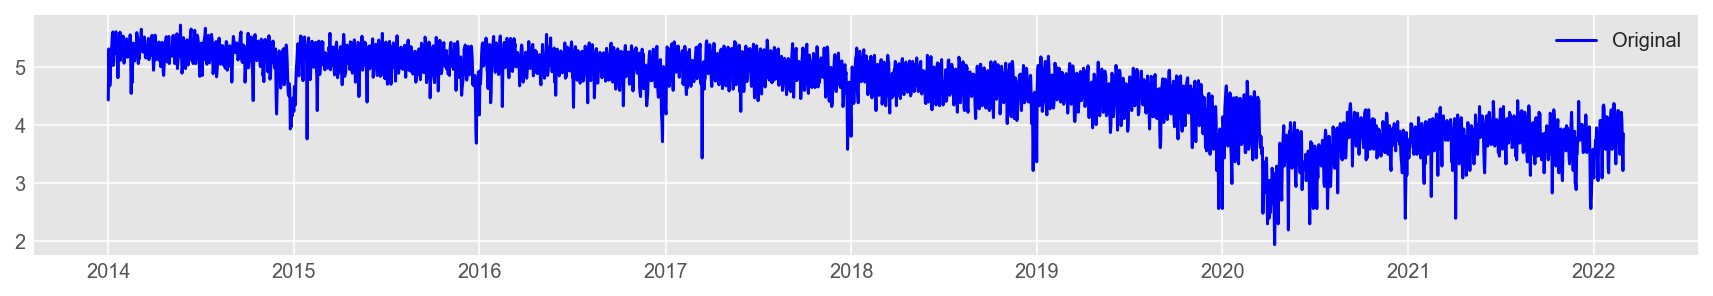

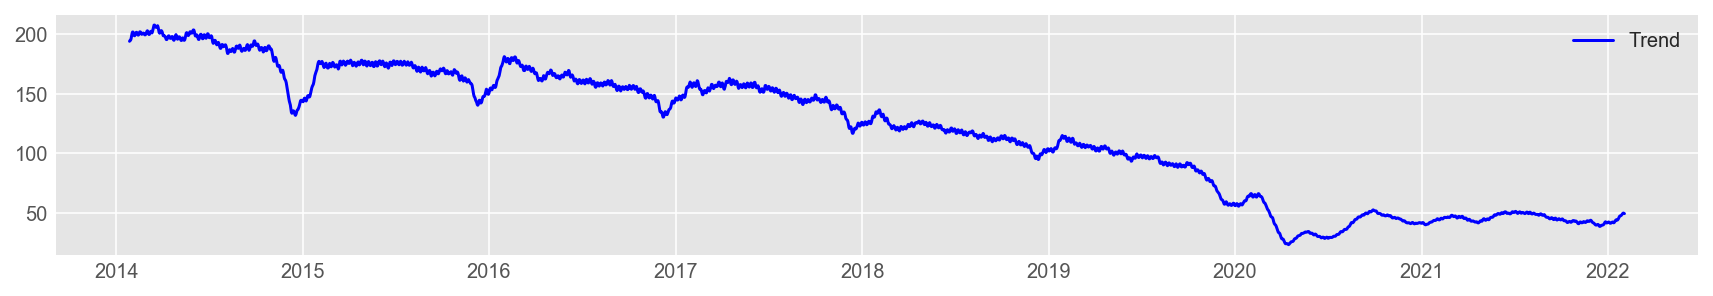

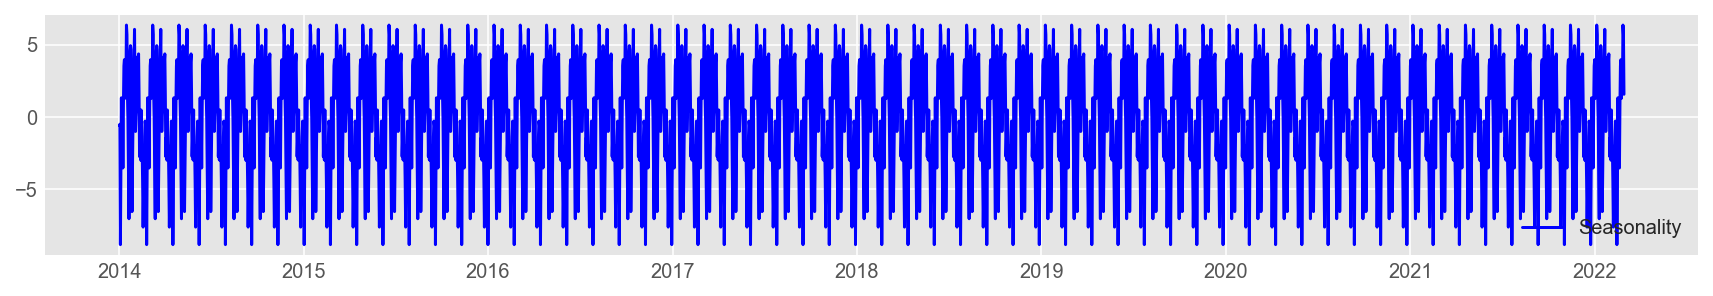

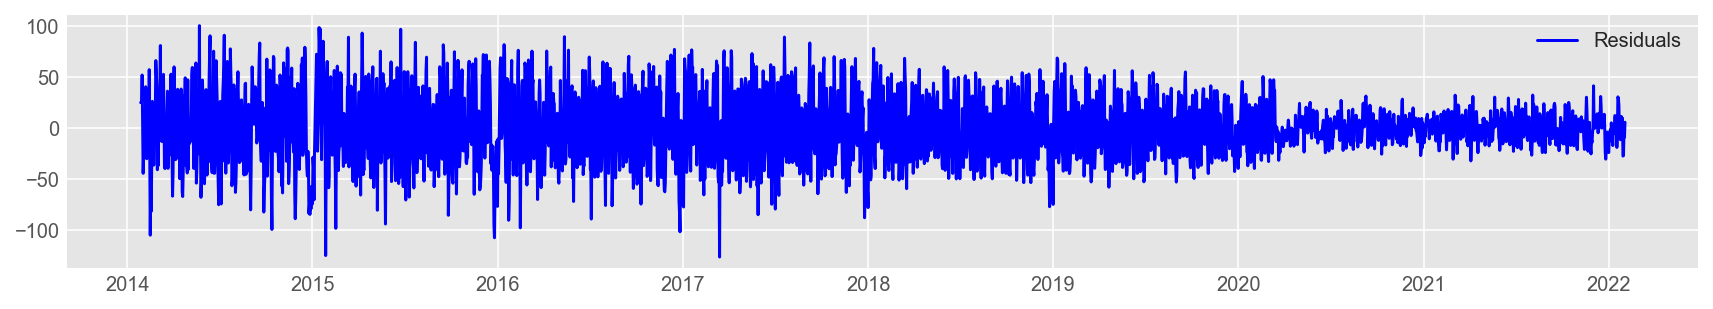

In [21]:
# decomposing seasons
def decompose(period, df):
    decomposition = seasonal_decompose(pred_df_day, period=period)

    # gather trend, seasonality, and noise of decomposed object

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(df), label = 'Original', color='blue')
    plt.legend(loc='best')

    plt.figure(figsize=(12,8))
    plt.subplot(412)
    plt.plot(trend, label = 'Trend', color='blue')
    plt.legend(loc='best')

    plt.figure(figsize=(12,8))
    plt.subplot(413)
    plt.plot(seasonal, label = 'Seasonality', color='blue')
    plt.legend(loc='best')

    plt.figure(figsize=(12,8))
    plt.subplot(414)
    plt.plot(residual, label = 'Residuals', color='blue')
    plt.legend(loc='best')
    
    plt.tight_layout()
decompose(1, pred_df_day) # year
decompose(12, pred_df_day) # monthly
decompose(52, pred_df_day) # weekly

In [22]:
# so according to this, there is no seasonality (how is seasonality defined in this way?)
# lots of noise
# general downward trend
# it's clearly not stationary - there's more in the tutorial but yeah

In [23]:
# Dickey-Fuller difference test
def difference_test(pred_df_day):
    dftest = adfuller(pred_df_day['inmateid_count'])
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value %s'%key] = value
    print(dfoutput)

In [24]:
# make the series stationary
# 52 and 1 both work pretty well bc p value is tiny for both, smaller for 52 though
pred_diff = pred_df_day.diff(periods=1).dropna()
difference_test(pred_diff)

Test Statistic                -1.680470e+01
p-value                        1.212398e-29
# Lags Used                    2.800000e+01
Number of Observations Used    2.951000e+03
Critical Value 1%             -3.432568e+00
Critical Value 5%             -2.862520e+00
Critical Value 10%            -2.567292e+00
dtype: float64


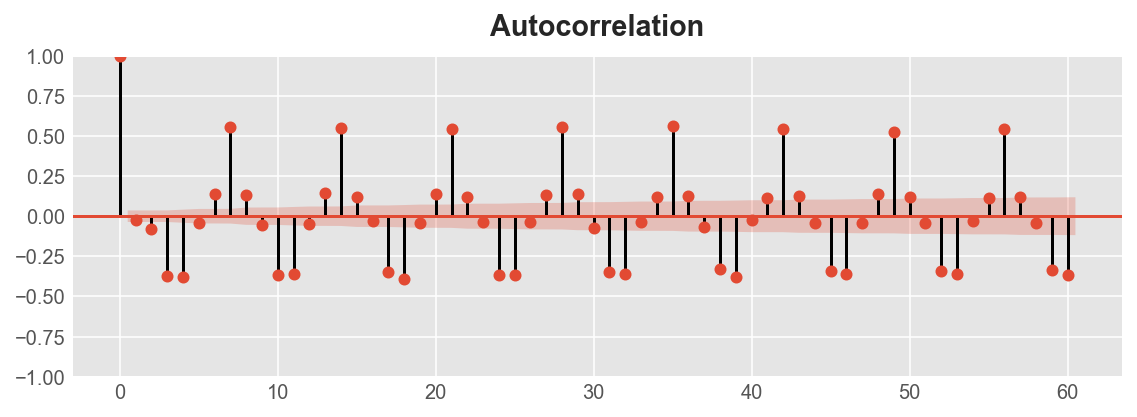

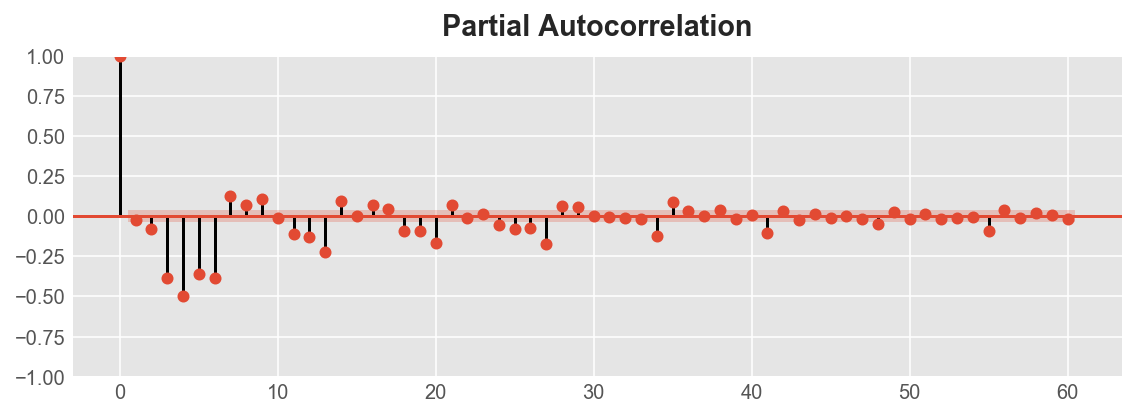

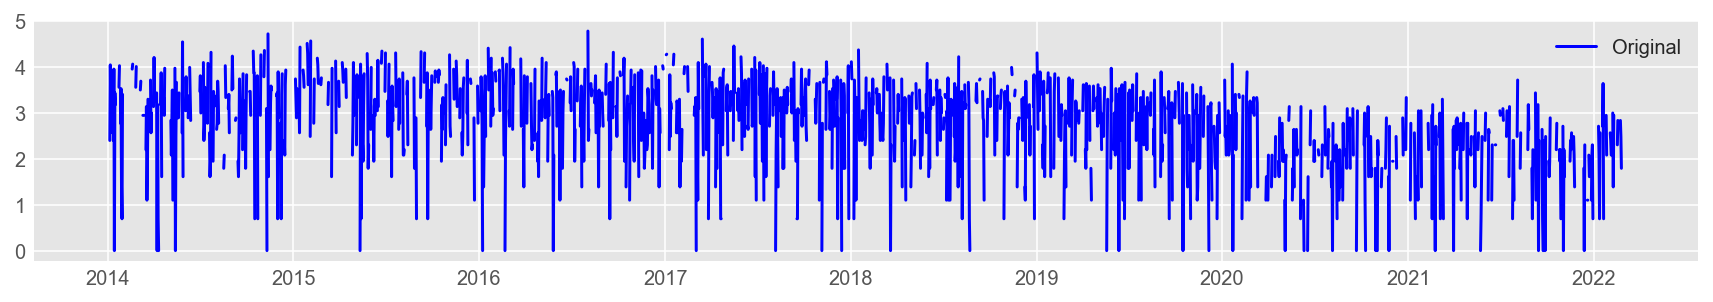

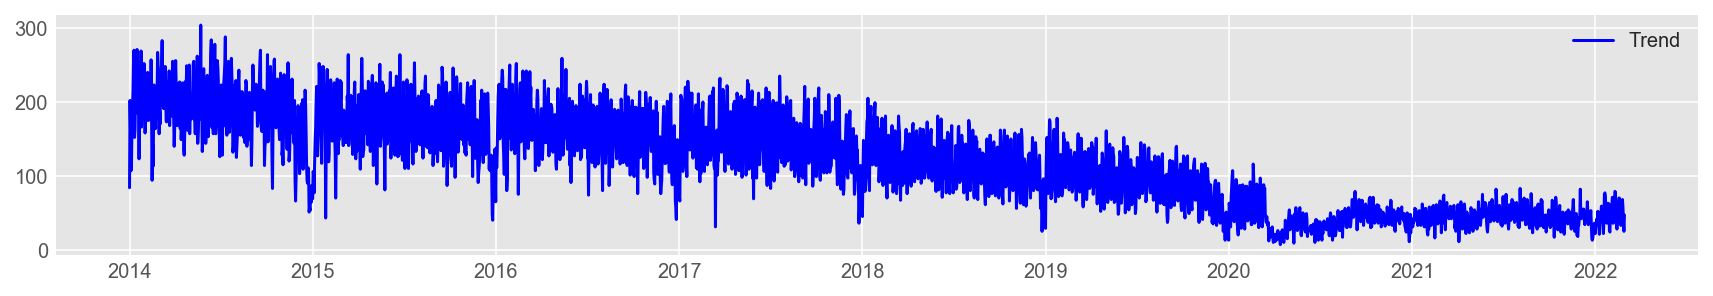

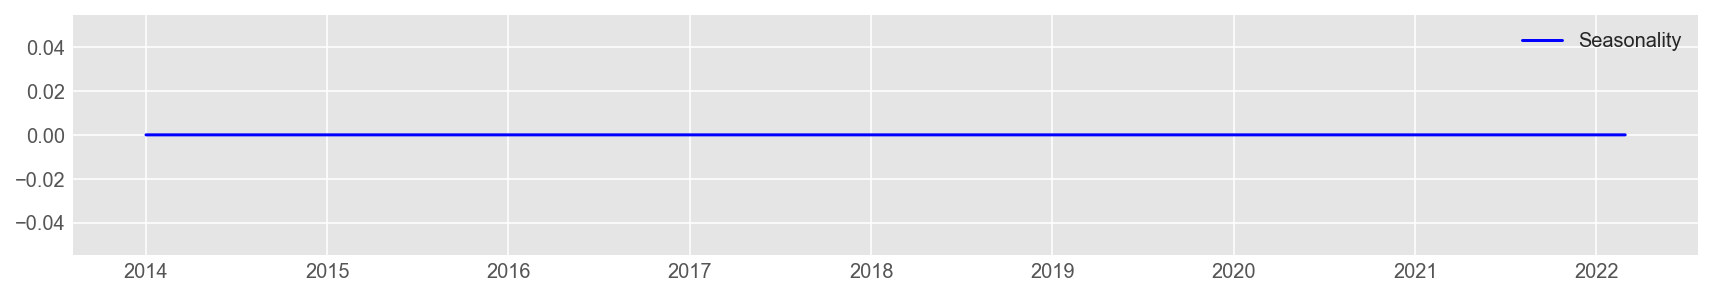

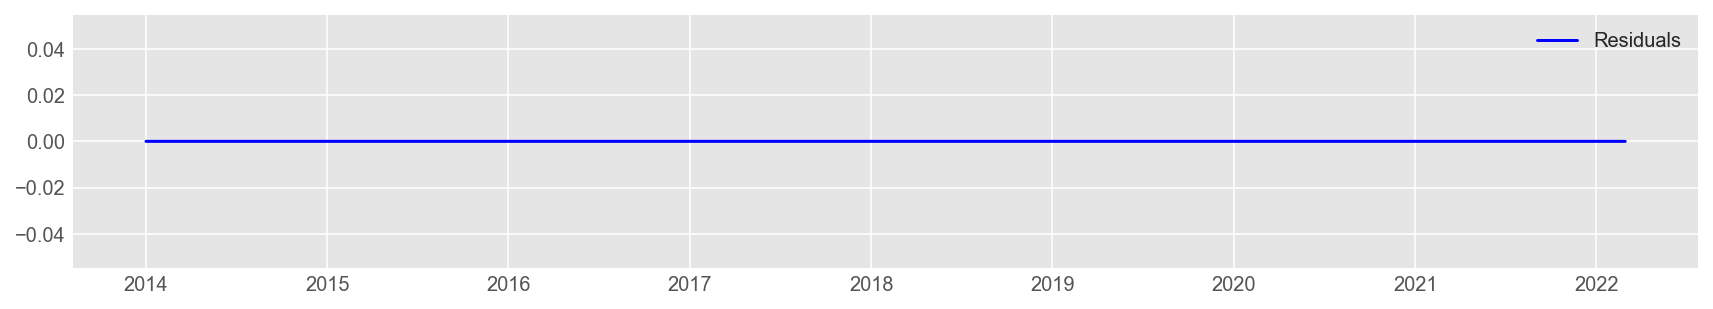

In [25]:
# create ACF and PACF plots to determine the p and q values
'''
PACF - gives the partial correlation of a time series with its own lagged values, 
controlling for the values of the time series at all shorter lags. 

ACF - The Autocorrelation Function gives the correlation of a time series with its 
own lagged values but without controlling the other lags.

ACF - get the AR(p)

'''

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(pred_diff, ax=ax, lags=60) # I'm confused about how to interpret the ACF plot 

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(pred_diff, ax=ax, lags=60)

decompose(1, pred_diff) # weekly

# suggests AR(p), p = 1, maybe q=1 or 10 for period=1

In [26]:
# d comes from number of differences to make stationary
# q comes from PACF plot
# p comes from ACF plot 

In [27]:
# just model, skip feature tuning for now

# takes t = triplet of d, q, p;
# takes ts = times series df
def sarima_model(t, ts):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    d = t[0]
    p = t[1]
    q = t[2]
    model = SARIMAX(ts, order=(p,d,q))
    model_fit = model.fit(disp=1,solver='powell')
    
    fcast = model_fit.get_prediction(start=1, end=len(ts))
    ts_p = fcast.predicted_mean
    ts_ci = fcast.conf_int()
    
    return model, ts_p, ts, ts_ci

In [28]:
def plot_model(ts_p, ts, ts_ci):
    plt.plot(ts_p,label='prediction')
    plt.plot(ts,color='red',label='actual')
    plt.fill_between(ts_ci.index[1:],
                    ts_ci.iloc[1:, 0],
                    ts_ci.iloc[1:, 1], color='k', alpha=.2)
    plt.ylabel('Total Number of Tourists Arrivals')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.savefig('IT_trend_prediction.png')
    plt.show()

In [29]:
# get best values for p, d, q for ARIMA model - this didn't work
def tune_sarima(df):
    # define the p, d, and q parameters to take any value between 0 an 2
    p = range(0,3)
    d = range(1,2)
    q = range(0,3)
    
    # Generate all different combinations of seasonal p, d, and q triplets
    pdq = list(itertools.product(p,d,q))
    
    # Generate all different combinations of seasonal p, d, and q triplets 
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
    
    ans = []
    
    for comb in pdq:
        for comb in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df['inmateid_count'],
                                               order=comb,
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
                
            except:
                continue
                
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df)
    print(ans_df.loc[ans_df['aic'].idxmin()])
    

In [6]:
# find best combination of parameters

In [30]:
def tune_sarima0(df):
    p = range(0, 3)
    d = range(1,2)
    q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    '''
    print('Examples of parameter combinations for Seasonal ARIMA...')
    
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    '''
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df['inmateid_count'], # y
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [ ]:
tune_sarima0(pred_df_day)

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:31315.061634646445
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:29037.897209062612
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:28903.479336711236
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:30791.03152032024
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:29034.52153973186
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:28828.451344513407
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:29446.05176768138
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:28469.472498163246
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:31275.922405746307
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:29057.41896756517
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:28872.432988210712
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:30746.918531049727
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:29020.54831250948


## Rishabh Sharma
https://medium.com/mlearning-ai/how-to-build-sarima-model-in-python-7ae83b14c884

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
%matplotlib inline
import itertools
import warnings
plt.style.use('ggplot')

In [17]:
# differencing
data["InmateID Count First Difference"] = data['inmateid_count'] - data['inmateid_count'].shift(1)
data.dropna(subset = ["InmateID Count First Difference"], inplace=True)
data.head()

NameError: name 'data' is not defined

In [18]:
ad_fuller_result = adfuller(data['InmateID Count First Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

NameError: name 'data' is not defined

In [ ]:
plt.figure(figsize=[12, 8]); # Set dimensions for figure
data['InmateID Count First Difference'].plot()
plt.title('Inmate Admissions - Differenced Series')
plt.ylabel('number of inmates')
plt.grid(True)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['InmateID Count First Difference'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['InmateID Count First Difference'].dropna(),lags=60,ax=ax2)


In [ ]:
tune_sarima0(pred_df_day)

In [ ]:
pred_diff

In [ ]:
# ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:27330.97952202711
data = pred_df_day
best_model = SARIMAX(data['inmateid_count'], order=(2, 1, 2), seasonal_order=(2, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())

In [ ]:
#Diagnosing the model residuals
best_model.plot_diagnostics(figsize=(15,12));

In [ ]:
# correlogram is still something to pay attention 

In [ ]:
data0 = data.reset_index()

In [ ]:
data

In [ ]:
forecast_values.predicted_mean
forecast_values_plot = pd.DataFrame(forecast_values.predicted_mean)
forecast_values_plot

In [ ]:
#Forecasting 10 years ahead
forecast_values = best_model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)#best_model.get_forecast(steps = 90)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = data0.plot(x="admitted_date", y='inmateid_count', figsize = (14, 6), legend = True, color='blue')

#Plot the forecasted values 
forecast_values_plot.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='red', alpha = .5)
plt.title('Electricity Net Generation From Coal, Electric Power Sector, Monthly', size = 16)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)
#annotation
ax.text(540, 400, 'Forecasted Values', fontsize=12,  color='red')

plt.figure(figsize=(12,8))

In [ ]:
data0.loc['2019-01-01':]['inmateid_count']
forecast_values.predicted_mean
(y_forecasted - y_truth)

y_truth
y_forecasted.reset_index()['predicted_mean']

forecast_values.predicted_mean.reset_index()['predicted_mean']
y_truth

In [ ]:
# converting the current date
# in datetime64 format

import numpy as np
from datetime import datetime
  
# converting date time into second timestamp 
#ts = (date64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

data['ts'] = data.admitted_date.apply(lambda x : (np.datetime64(x) - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))

data.set_index('ts', inplace=True)

In [ ]:
data.reset_index(inplace=True)
data['admitted_date']=data.admitted_date.apply(lambda x: pd.Timestamp(x))
data.set_index('admitted_date', inplace=True)

In [ ]:
data=data.drop(columns=['level_0', 'index'])

In [ ]:
data = data.drop(columns=['index', 'ts'])

In [ ]:
data = data.reset_index()
data1 = data.copy()
data.set_index('admitted_date',inplace=True)

In [ ]:
start
end

In [ ]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.model_selection import train_test_split

'''
#data['ts'] = data.index.values.astype(np.int64) // 10 ** 9
#data.set_index('ts', inplace=True)
X = data1.admitted_date.apply(lambda x: pd.Timestamp(x))

y = data.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)


y_fit = pd.DataFrame(best_model.predict(X_train))# index=X_train.index))# columns=y.columns))
y_pred = pd.DataFrame(best_model.predict(X_test))#index=X_test.index)) # columns=y.columns))

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
print("Test R2", r2) # https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean

'''

train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1

predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['inmateid_count'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['inmateid_count'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['inmateid_count'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['inmateid_count'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['inmateid_count'])/np.abs(test['inmateid_count']))*100 
evaluation_results


In [ ]:
# could be worse - 32.7 percent accuracy. Maybe do better hyperparameter tuning. 

## RELU Neural Network approach: use kalman filter to reduce noise

In [19]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from kerashypetune import KerasGridSearch

In [20]:
df = pred_df_day
df

,inmateid_count
admitted_date,
2014-01-01,84
2014-01-02,202
2014-01-03,162
2014-01-04,107
2014-01-05,118
...,...
2022-02-24,68
2022-02-25,58
2022-02-26,37


In [21]:
### USE KALMAN FILTER TO SMOOTH ALL DATA (ONLY VISUALIZATION PURPOSE) ###

smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother.smooth(df[['inmateid_count']].T)

<tsmoothie.smoother.KalmanSmoother>

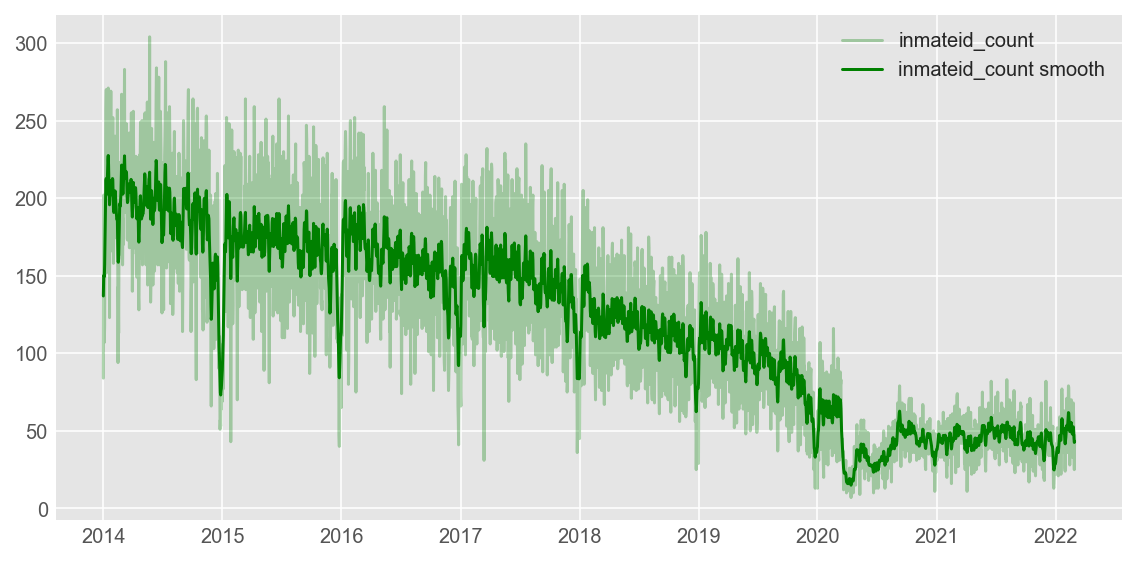

In [22]:
### PLOT RAW vs SMOOTHED DATA ###

color = {0:'green'}

for i,name in enumerate(df.columns):
    plt.figure(figsize=(8,4))
    plt.plot(df.index, smoother.data[i], c=color[i], label=name, alpha=0.3)
    plt.plot(df.index, smoother.smooth_data[i], c=color[i], label=name+' smooth')
    plt.legend(); plt.show()

In [23]:
### TRAIN TEST SPLIT ###

X_train_val, X_test, y_train_val, y_test = train_test_split(df[['inmateid_count']].values, 
                                                            df[['inmateid_count']].values, test_size=0.2, shuffle=False)

y_train_val.shape, y_test.shape

((2384, 1), (597, 1))

In [25]:
### USE KALMAN FILTER TO SMOOTH ONLY THE TARGET ON TRAIN/VAL DATA ###

smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother.smooth(y_train_val.T)

<tsmoothie.smoother.KalmanSmoother>

In [26]:
### SLICE TRAIN/VAL DATA INTO EQUAL SLIDING WINDOWS ###

window_shape = 20
target_seq = 14#5

X_train_val = create_windows(X_train_val, window_shape=window_shape, 
                             end_id=-target_seq)
X_train_val.shape

(2351, 20, 1)

In [27]:
### SLICE TEST DATA INTO EQUAL SLIDING WINDOWS ###

X_test = create_windows(X_test, window_shape=window_shape, 
                        end_id=-target_seq)
X_test.shape

(564, 20, 1)

In [28]:
### CREATE SLIDING WINDOWS RAW TRAIN/VAL TARGET ###

y_train_val = create_windows(smoother.data.T, window_shape=target_seq, 
                             start_id=window_shape)
y_train_val.shape

(2351, 14, 1)

In [29]:
### CREATE SLIDING WINDOWS SMOOTH TRAIN/VAL TARGET ###

y_smooth_train_val = create_windows(smoother.smooth_data.T, window_shape=target_seq, 
                                    start_id=window_shape)
y_smooth_train_val.shape

(2351, 14, 1)

In [30]:
### SLICE TEST TARGET INTO EQUAL SLIDING WINDOWS ###

y_test = create_windows(y_test, window_shape=target_seq, 
                        start_id=window_shape)
y_test.shape

(564, 14, 1)

In [31]:
### TRAIN VAL SPLIT ###

X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_train_val, y_train_val, test_size=0.1, shuffle=False)
X_train, X_val, y_train_smooth, y_val_smooth = train_test_split(X_train_val, y_smooth_train_val, test_size=0.1, shuffle=False)

In [32]:
### SCALE INPUT ###

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


In [33]:
### SCALE SMOOTH TARGET ###

scaler_target_smooth = StandardScaler()
y_train_smooth = scaler_target_smooth.fit_transform(y_train_smooth.reshape(-1, y_train_smooth.shape[-1])).reshape(y_train_smooth.shape)
y_val_smooth = scaler_target_smooth.transform(y_val_smooth.reshape(-1, y_val_smooth.shape[-1])).reshape(y_val_smooth.shape)


In [34]:
### SCALE RAW TARGET ###

scaler_target = StandardScaler()
y_train_raw = scaler_target.fit_transform(y_train_raw.reshape(-1, y_train_raw.shape[-1])).reshape(y_train_raw.shape)
y_val_raw = scaler_target.transform(y_val_raw.reshape(-1, y_val_raw.shape[-1])).reshape(y_val_raw.shape)

In [35]:
### UTILITY FUNCTIONS FOR HYPERPARAM SEARCH ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)

    model = Sequential()
    model.add(LSTM(param['unit'], activation=param['act']))
    model.add(RepeatVector(target_seq))
    model.add(LSTM(param['unit'], activation=param['act'], return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    opt_choices = {'adam': Adam(),
                   'rms': RMSprop()}
    
    opt = opt_choices[param['opt']]
    opt.lr = param['lr'] 
    
    model.compile(opt, 'mse')
    
    return model

In [36]:
### CREATE GRID FOR HYPERPARAM SEARCH ###

param_grid = {
    'unit': [128,64,32], 
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'opt': ['adam','rms'],
    'epochs': 200,
    'batch_size': 512
    }

In [37]:
### FIT + HYPERPARAM SEARCH WITH RAW TARGET ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = get_model

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_raw, validation_data=(X_val, y_val_raw), callbacks=[es])



24 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size')

***** (1/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.30316 at epoch 14

***** (2/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.34919 at epoch 54

***** (3/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.66556 at epoch 26

***** (4/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 1.30024 at epoch 1

***** (5/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.2957 at epoch 16

***** (6/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.27569 at epoch 9

***** (7/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 

In [38]:
### GET BEST STATISTICS ###

kgs.best_score, kgs.best_params


(0.20057,
 {'unit': 32,
  'lr': 0.001,
  'act': 'elu',
  'opt': 'rms',
  'epochs': 30,
  'batch_size': 512,
  'steps_per_epoch': 5})

In [39]:
### REVERSE PREDICTIONS ###

pred_raw = kgs.best_model.predict(X_test)
pred_raw = scaler_target.inverse_transform(pred_raw.reshape(-1, pred_raw.shape[-1])).reshape(pred_raw.shape)

In [40]:
### CALCULATE MSE FOR EACH PREDICTION HORIZONS ###

mse_raw = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[:,i,0], pred_raw[:,i,0])
    mse_raw['day + {i}'.format(i=i+1)] = mse
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

pred day + 1: 203.29768277299107 MSE
pred day + 2: 292.48854474882654 MSE
pred day + 3: 338.191857892047 MSE
pred day + 4: 278.73431698928067 MSE
pred day + 5: 204.75944520736368 MSE
pred day + 6: 163.90186103404028 MSE
pred day + 7: 168.9294278060206 MSE
pred day + 8: 209.5611111375212 MSE
pred day + 9: 250.52154656949236 MSE
pred day + 10: 265.3758655568509 MSE
pred day + 11: 247.43548477540799 MSE
pred day + 12: 211.38199084710175 MSE
pred day + 13: 193.12576571087394 MSE
pred day + 14: 207.92713501796706 MSE


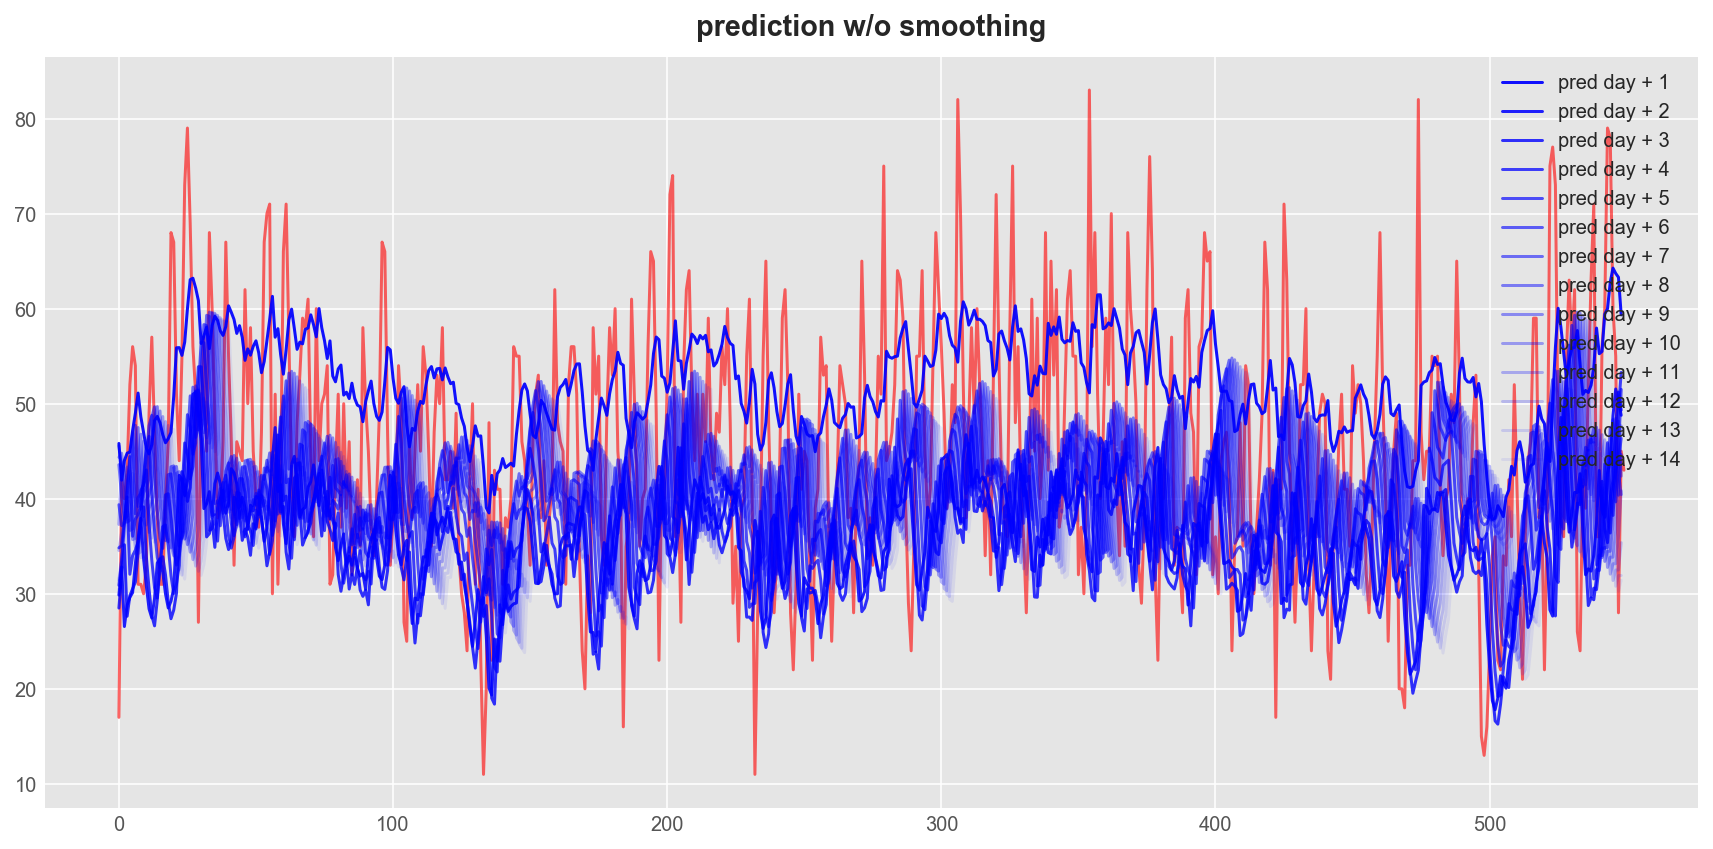

In [41]:
### PLOT EACH PREDICTION HORIZONS ON THE SAME PLOT ###

plt.figure(figsize=(12,6))

plt.plot(y_test[target_seq:,0,0], c='red', alpha=0.6)

for i in range(target_seq):
        
    plt.plot(pred_raw[(target_seq-i):-(i+1),i,0], 
             c='blue', alpha=1-1/(target_seq+1)*(i+1),
             label='pred day + {i}'.format(i=i+1))
    
plt.title('prediction w/o smoothing'); plt.legend()

In [42]:
### FIT + HYPERPARAM SEARCH WITH SMOOTH TARGET ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = get_model

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_smooth, validation_data=(X_val, y_val_smooth), callbacks=[es])


24 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size')

***** (1/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.63853 at epoch 18

***** (2/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.52983 at epoch 50

***** (3/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.4575 at epoch 14

***** (4/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.2833 at epoch 36

***** (5/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.24124 at epoch 19

***** (6/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.22594 at epoch 14

***** (7/24) *****
Search({'unit': 128, 'lr': 0.001, 'act':

In [43]:
### GET BEST STATISTICS ###

kgs.best_score, kgs.best_params

(0.15048,
 {'unit': 64,
  'lr': 0.001,
  'act': 'elu',
  'opt': 'rms',
  'epochs': 21,
  'batch_size': 512,
  'steps_per_epoch': 5})

In [44]:
### REVERSE PREDICTIONS ###

pred_smooth = kgs.best_model.predict(X_test)
pred_smooth = scaler_target_smooth.inverse_transform(pred_smooth.reshape(-1, pred_smooth.shape[-1])).reshape(pred_smooth.shape)

In [45]:
### CALCULATE MSE FOR EACH PREDICTION HORIZONS ###

mse_smooth = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[:,i,0], pred_smooth[:,i,0])
    mse_smooth['day + {i}'.format(i=i+1)] = mse 
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

pred day + 1: 266.4858019115368 MSE
pred day + 2: 209.0180466732367 MSE
pred day + 3: 184.33978997893465 MSE
pred day + 4: 172.79548876753063 MSE
pred day + 5: 162.81572402017386 MSE
pred day + 6: 158.22688550600034 MSE
pred day + 7: 166.5546563377741 MSE
pred day + 8: 184.76063253231334 MSE
pred day + 9: 198.96058062635876 MSE
pred day + 10: 199.06131752327397 MSE
pred day + 11: 185.0374072596814 MSE
pred day + 12: 165.775204892468 MSE
pred day + 13: 158.49960573480254 MSE
pred day + 14: 166.16158085169394 MSE


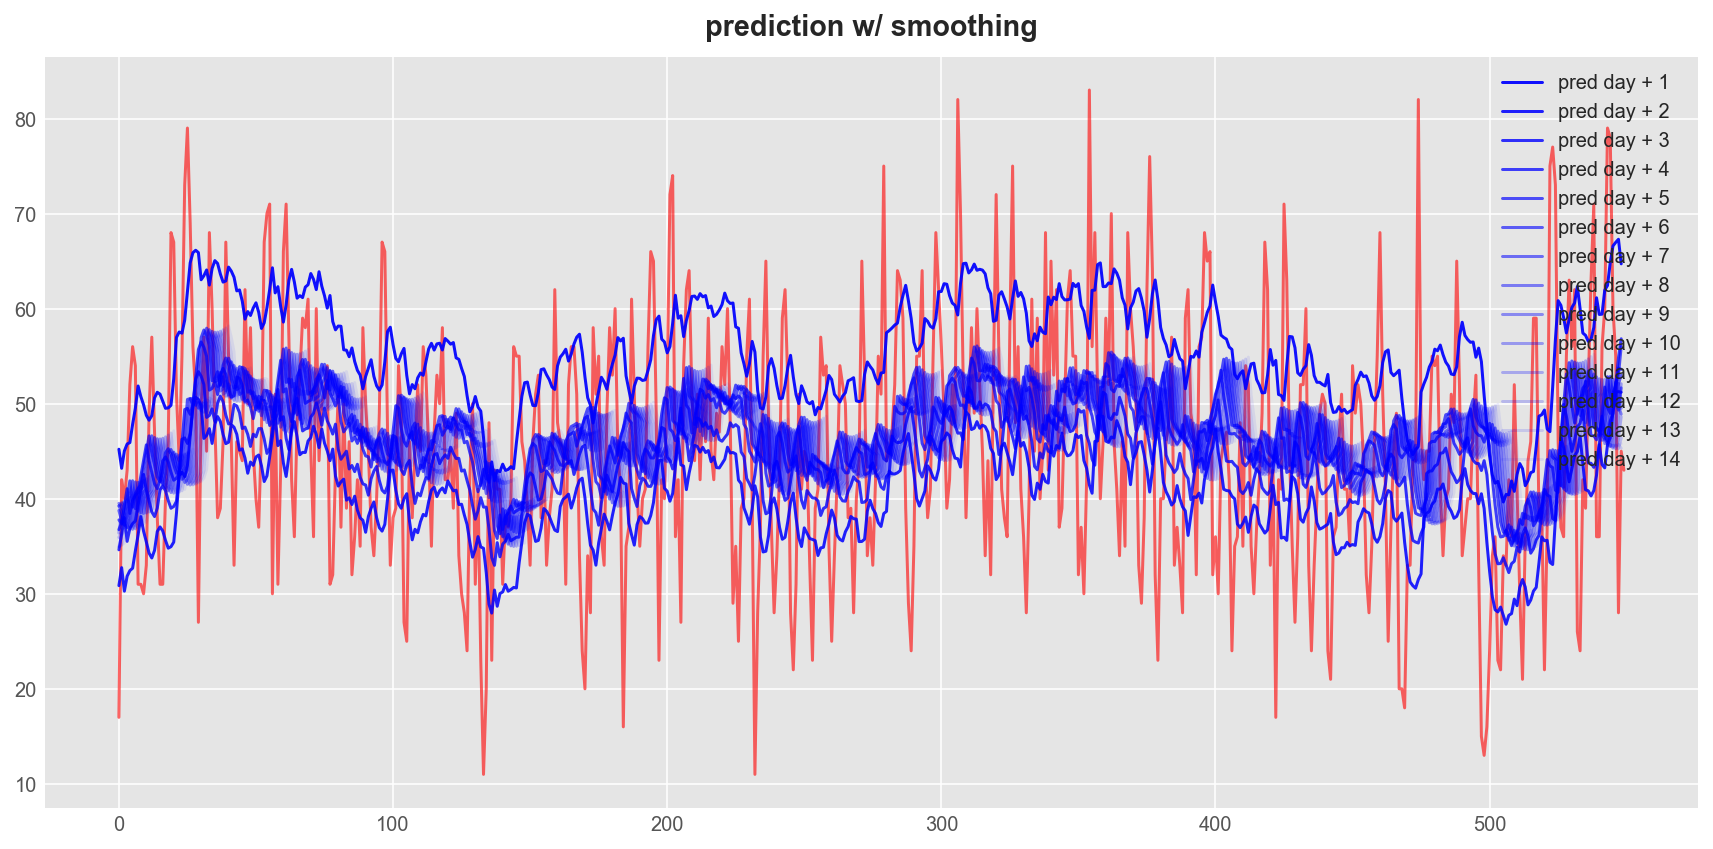

In [46]:
### PLOT EACH PREDICTION HORIZON ON THE SAME PLOT ###

plt.figure(figsize=(12,6))

plt.plot(y_test[target_seq:,0,0], c='red', alpha=0.6)

for i in range(target_seq):
        
    plt.plot(pred_smooth[(target_seq-i):-(i+1),i,0], 
             c='blue', alpha=1-1/(target_seq+1)*(i+1),
             label='pred day + {i}'.format(i=i+1))
    
plt.title('prediction w/ smoothing'); plt.legend()

In [47]:
### CALCULATE BASELINE MSE FOR EACH PREDICTION HORIZONS ###

mse_baseline = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[1:,i,0], y_test[:-1,0,0])
    mse_baseline['day + {i}'.format(i=i+1)] = mse 
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

pred day + 1: 177.00888099467142 MSE
pred day + 2: 309.4103019538188 MSE
pred day + 3: 428.8436944937833 MSE
pred day + 4: 433.6323268206039 MSE
pred day + 5: 338.6341030195382 MSE
pred day + 6: 218.37300177619895 MSE
pred day + 7: 166.40142095914743 MSE
pred day + 8: 236.30017761989342 MSE
pred day + 9: 359.98756660746005 MSE
pred day + 10: 457.01776198934283 MSE
pred day + 11: 462.31261101243336 MSE
pred day + 12: 355.8081705150977 MSE
pred day + 13: 241.02841918294848 MSE
pred day + 14: 171.92184724689164 MSE


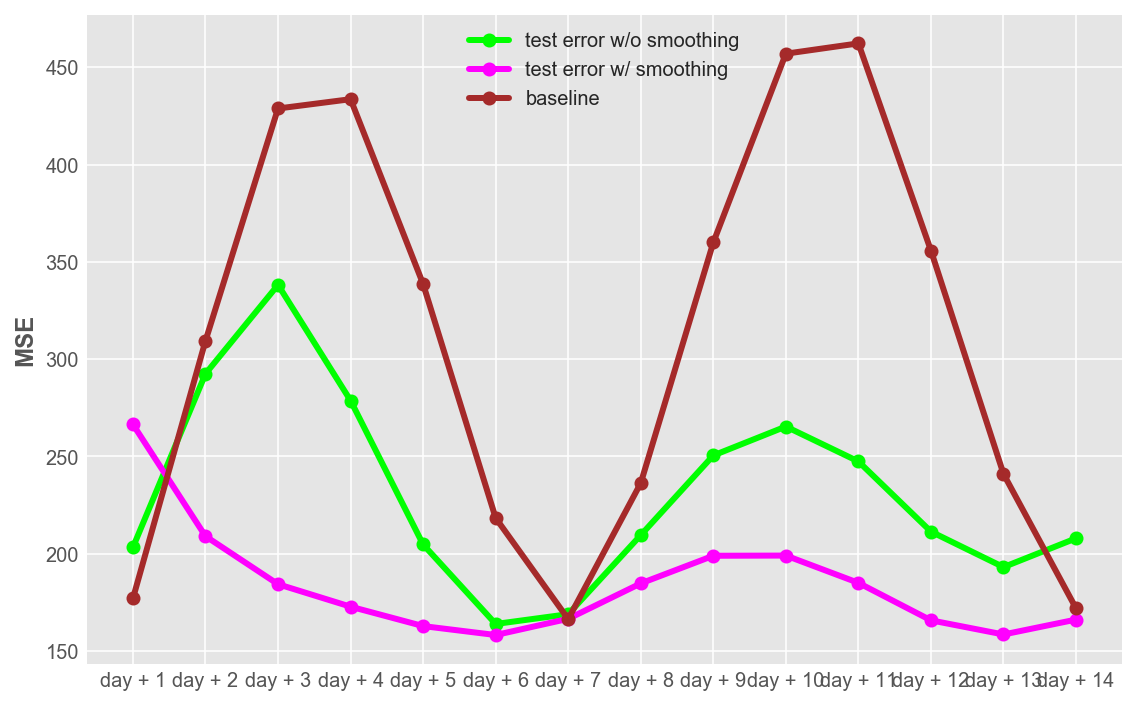

In [48]:
### PLOT MSE FOR EACH PREDICTION HORIZONS ###

plt.figure(figsize=(8,5))

plt.plot(list(mse_raw.values()), label='test error w/o smoothing', 
         c='lime', linewidth=3, marker='o')
plt.plot(list(mse_smooth.values()), label='test error w/ smoothing', 
         c='magenta', linewidth=3, marker='o')
plt.plot(list(mse_baseline.values()), label='baseline', 
         c='brown', linewidth=3, marker='o')

plt.xticks(range(target_seq), mse_smooth.keys())
plt.ylabel('MSE'); plt.legend()
np.set_printoptions(False)

In [49]:
kgs.best_model

In [50]:
from sklearn.metrics import r2_score

### CALCULATE BASELINE MSE FOR EACH PREDICTION HORIZONS ###

r2_smooth = {}

for i in range(target_seq):
    
    r2 = r2_score(y_test[:,i,0], pred_smooth[:,i,0])
    r2_smooth['day + {i}'.format(i=i+1)] = r2 
    
    print('pred day + {i}: {r2} R2'.format(i=i+1, r2=r2))


pred day + 1: -0.5461365694303684 R2
pred day + 2: -0.22063263269760203 R2
pred day + 3: -0.07435956136340427 R2
pred day + 4: -0.003610419377781504 R2
pred day + 5: 0.053600097406144354 R2
pred day + 6: 0.0801222976768089 R2
pred day + 7: 0.03269110662412644 R2
pred day + 8: -0.07303613076269033 R2
pred day + 9: -0.15411999737262105 R2
pred day + 10: -0.1532628173973114 R2
pred day + 11: -0.07457169278930298 R2
pred day + 12: 0.03644474660871311 R2
pred day + 13: 0.08269440022274988 R2
pred day + 14: 0.03818067875790032 R2


still terrible. welp. guess I can't predict this afterall. 